### NOTE: Neither the lines of code nor text have been proofread

In [50]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### Color Spaces: Extension

**Detecting a basket**

This is a truly challenging task in which I attempt to detect a basket using color spaces

(<matplotlib.image.AxesImage at 0x1c93e66b208>, ([], []), ([], []))

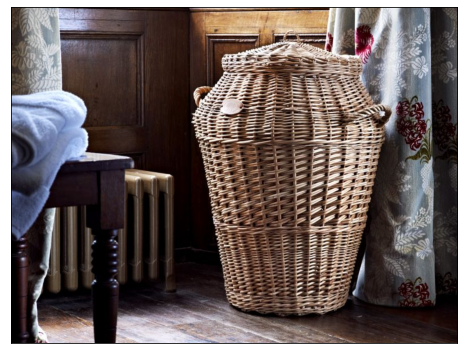

In [16]:
img = cv.imread('bank_images/test11.png')

# View on Matplotlib
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize=(8,7))
plt.imshow(rgb_img), plt.xticks([]), plt.yticks([])

The first thing the experienced eye will notice is that our basket has different shades of lightness; this *will* impact on our ability to use color spaces to detect it. We will need to consider hue, saturation and value/brightness. I have used a 3D graph to help with this, but before I show this, I want to revisit RGB histograms as I found something unexpected

In [62]:
h = np.zeros((300,256,3))
bins = np.arange(256).reshape(256,1)
color = [ (255,0,0),(0,255,0),(0,0,255) ]

for ch,col in enumerate(color):
    hist_item = cv.calcHist([img],[ch],None,[256],[0,256])
    cv.normalize(hist_item,hist_item,0,255,cv.NORM_MINMAX)
    hist = np.int32(np.around(hist_item))
    pts = np.column_stack((bins,hist))
    cv.polylines(h,[pts],False,col)

h=np.flipud(h)

cv.imshow('colorhist',h)
cv.waitKey(0)
cv.destroyAllWindows()

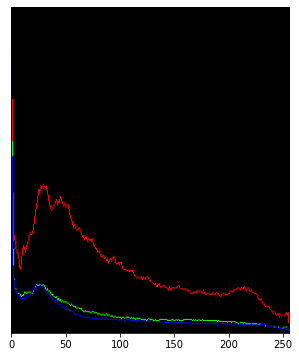

In [39]:
h = np.zeros((300,256,3))
bins = np.arange(256).reshape(256,1)
color = [ (255,0,0),(0,255,0),(0,0,255) ]
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # So that we view correctly with Matplotlib

for ch,col in enumerate(color):
    hist_item = cv.calcHist([rgb_img],[ch],None,[256],[0,255])
    cv.normalize(hist_item,hist_item,0,255,cv.NORM_MINMAX)
    hist = np.int32(np.around(hist_item))
    pts = np.column_stack((bins,hist))
    cv.polylines(h,[pts],False,col)
    
h=np.flipud(h)

plt.figure(figsize=(6,6)), plt.yticks([])
plt.imshow(h.astype('uint8'))

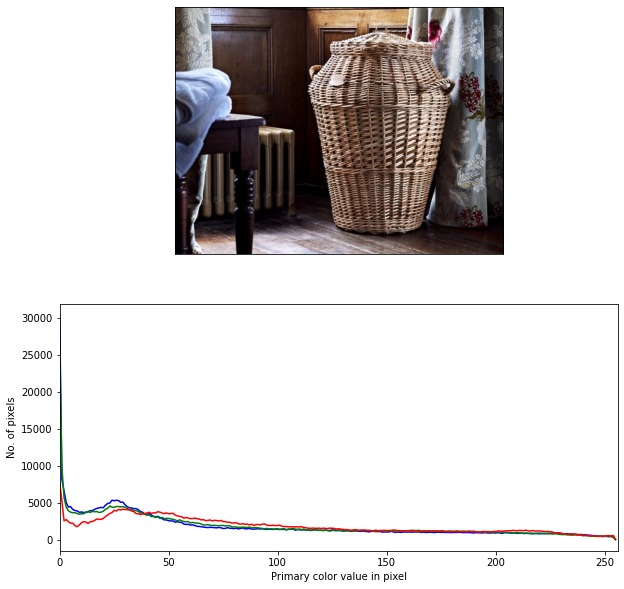

In [67]:
color = ('b','g','r')

plt.figure(figsize=(10,10))
plt.subplot(2,1,1), plt.imshow(rgb_img), plt.xticks([]), plt.yticks([])
plt.subplot(2,1,2),plt.xlabel('Primary color value in pixel'),plt.ylabel('No. of pixels')
for i,col in enumerate(color):
    histr = cv.calcHist([img],[i],None,[256],[0,255])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.savefig('baskethisto.png')

The Matplotlib histogram looks different to the OpenCV one. I'm not entrely sure why; the red appears off-kilter. I did some research on this

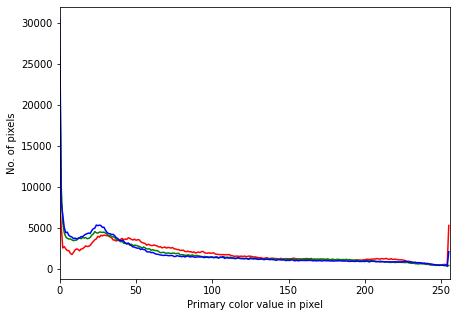

In [42]:
# np.histogram()

col = ("red", "green", "blue")  # Because Numpy is producing the histogram, we use RGB

plt.figure(figsize=(7,5))
plt.xlabel('Primary color value in pixel'),plt.ylabel('No. of pixels')
for ch,col in enumerate(col):
    hist,bins = np.histogram(rgb_img[:,:,ch],256,[0,256])
    plt.plot(bins[0:-1],hist,color = col)
    plt.xlim([0,256])

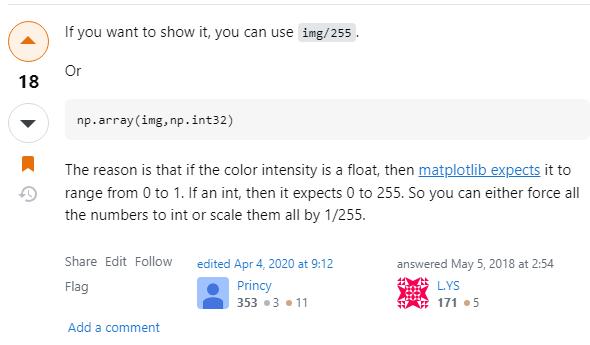

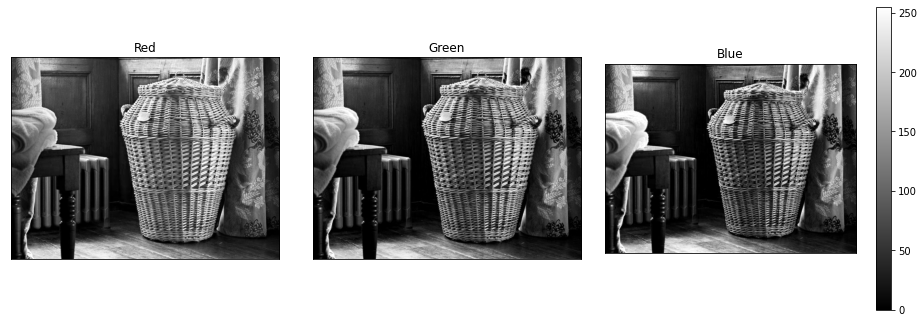

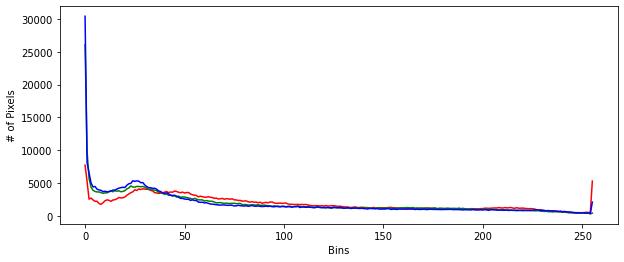

In [68]:
im = np.array(Image.open('bank_images/test11.png'))
channelNames=['Red','Green','Blue']

fig, axes = plt.subplots(1,3,figsize=(14,4))
for channel, ax in enumerate(axes):
    imshow=ax.imshow(im.T[channel].T, cmap=plt.cm.gray, vmin=0, vmax=255)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(channelNames[channel])

fig.colorbar(imshow,fraction=0.06, pad=0.07, shrink=1.5)
fig.tight_layout()
fig.subplots_adjust(right=0.9)

fig, ax = plt.subplots(1, figsize=(10,4))
for channel in range(3):
    cts = np.bincount(im.T[channel].flatten())
    bins=np.arange(0,256,1)
    ax.plot(bins, cts, c=channelNames[channel])
ax.set_xlabel('Bins')
ax.set_ylabel('# of Pixels')

plt.savefig('channel.png')

It appears the graphs are 'the same'; it's just that the red has been 'squeezed' in the OpenCV histogram, but as the above shows, more pixels have a high red value than blue or green, which is reflected in the channel pictures above

Now back to HSV and 3D!

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

Save graph? (Y/N) : n
Not saved


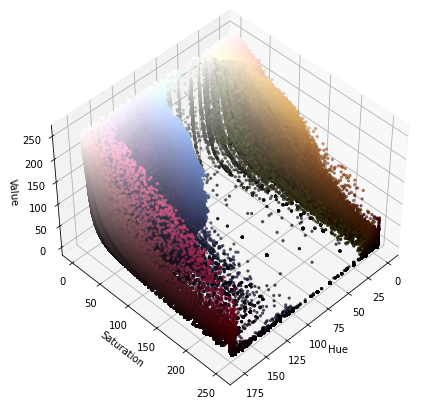

In [5]:
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
pixel_colors = rgb_img.reshape((np.shape(rgb_img)[0]*np.shape(rgb_img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

hsv = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)
h, s, v = cv.split(hsv)
fig = plt.figure(figsize=(8,7))

axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".", alpha=0.6)
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.view_init(elev=45, azim=45)
# axis.view_init(elev=15, azim=90) # Alternative view(s)

save = input('Save graph? (Y/N) : ')
if save == 'Y'.lower():
    plt.savefig('save3d.png')
else:
    print('Not saved')

Now I can make out the rough HSV range for our basket; I will plug the estimates into my code

(Because Matplotlib uses RGB and OpenCV uses BGR, to confirm that my conversion from OpenCV to Matplotlib is correct and the colors in my HSV profile are in the right places, I can always check with an online HSV color picker such as https://www.rapidtables.com/web/color/color-picker.html)

(<matplotlib.image.AxesImage at 0x26ab9cda988>, ([], []), ([], []))

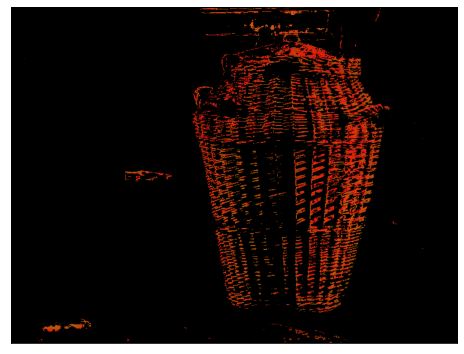

In [38]:
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
lower_hsv = np.array([[[10, 20, 150]]])
upper_hsv = np.array([[[15, 100, 255]]])

mask = cv.inRange(hsv, lower_hsv, upper_hsv)
res = cv.bitwise_and(hsv,hsv, mask=mask)

rgb_res = cv.cvtColor(res, cv.COLOR_BGR2RGB)
plt.figure(figsize=(8,7))
plt.imshow(rgb_res), plt.xticks([]), plt.yticks([])

The basket is very difficult to isolate without losing a significant amount of information. I am also finding out that if I try to set my hue towards the color I am perceiving the basket to be, I end up picking up a lot of noise and so I am forced to set my hue range towards red. The alternative view of the 3D plot of my image's HSV profile reveals why

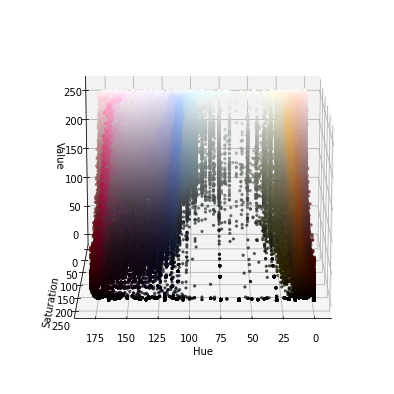

In [49]:
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
pixel_colors = rgb_img.reshape((np.shape(rgb_img)[0]*np.shape(rgb_img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

hsv = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)
h, s, v = cv.split(hsv)
fig = plt.figure(figsize=(8,7))

axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".", alpha=0.6)
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
axis.view_init(elev=15, azim=90)

Notice how entangled the perceived basket color is with red; restricting my hue to red minimises noise but gives me an unsatisfactory result. I will be revisiting this basket again! 